In [1]:
import sys
sys.path.append('/Users/samrelins/Documents/LIDA/ace_project/')

from IPython.display import Image
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pymc3 as pm
from sklearn.metrics import roc_auc_score
from src.train_test import *
from src.data_prep import *

from scipy import stats


# load and prep data
data_dir = "/Users/samrelins/Documents/LIDA/ace_project/data/"
data_path = os.path.join(data_dir, "ace_data_extra.csv")
ace_dat = pd.read_csv(data_path)

X_train, y_train, X_test, y_test = return_train_test(ace_dat)
X_train, X_test = encode_and_scale(
    X_train, y_train, X_test, 
    cat_encoder="one_hot", 
    scaled=True
)


def sample_distribution(X_train, y_train, features):
    """
    Helper function to sample logistic regression bayes model
    
    :param X_train: (object: pandas DataFrame) input training data dataframe
    :param y_train: (object: pandas Series) training labels
    :param features: (list) list of features / columns to use 
        in logistic regression model
    
    :return: (tuple: (object: pyMC3 Model, object: pyMC3 Trace) 
        pyMC3 model and trace objects from sampler
    
    """
    with pm.Model() as model:
        pm.glm.GLM(
            x = X_train[features],
            y = y_train,
            intercept=True,
            family=pm.glm.families.Binomial()
        )
        trace = pm.sample(2000, 
                          tune=500, 
                          cores=14,  
                          target_accept=0.90,
                          init="adapt_diag")
    return model, trace
        
    
def return_kde_plot(samples, step=0.001, color="red"):
    """
    returns plolty scatter plot of np.array KDE
    """
    kde = stats.gaussian_kde(samples)
    xx = np.arange(samples.min(), samples.max(), step)
    yy = kde.evaluate(xx)
    kde_plot = go.Scatter(x=xx, 
                          y=yy, 
                          line=dict(color=color,
                                    shape="spline"),
                          mode="lines",
                          fill="tozeroy")
    return kde_plot
        
        
def return_trace_fig(pymc_trace):
    """
    Helper function to plot trace and KDE plots from pyMC3 samples
    
    :param pymc_trace: (object: pyMC3 Trace object) input trace
    
    :return: plotly Figure
    """
    
    subplot_titles = []
    for title in pymc_trace.varnames:
        subplot_titles += [title, ""]
    fig = make_subplots(rows=len(pymc_trace.varnames), 
                        cols=2,
                        subplot_titles=subplot_titles)

    for i, feature in enumerate(pymc_trace.varnames):
        samples = pymc_trace[feature]
        color = px.colors.qualitative.Plotly[i%10]
        
        trace_plot = go.Scatter(x=np.arange(len(samples)), 
                                y=samples,
                                line=dict(color=color))
        fig.add_trace(trace_plot, row=i+1, col=1)
        
        kde_plot = return_kde_plot(samples, color=color)
        fig.add_trace(kde_plot, row=i+1, col=2)

    fig.update_layout(height=200*len(pymc_trace.varnames),
                      showlegend=False)
    return fig

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '22588' (I am process '22652')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 54 seconds.
The number of effective samples is smaller than 25% for some parameters.


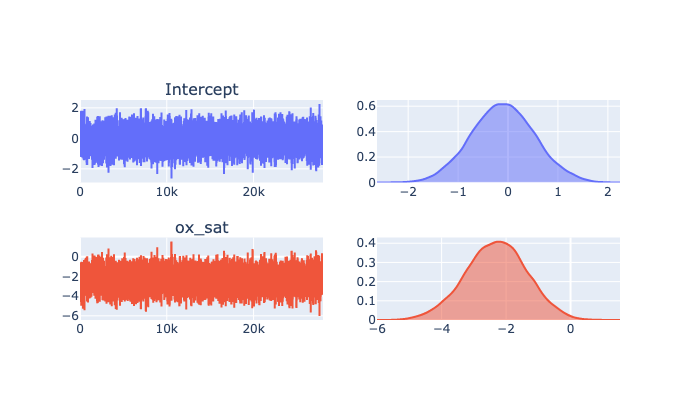

In [2]:
eg_model, eg_trace = sample_distribution(X_train, y_train, ["ox_sat"])
trace_fig = return_trace_fig(eg_trace)
Image(trace_fig.to_image(format="png"))

In [3]:
eg_hpd_results = pm.hpd(eg_trace, hdi_prob=0.95)
eg_hpd_results

<xarray.Dataset>
Dimensions:    (hdi: 2)
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept  (hdi) float64 -1.377 1.107
    ox_sat     (hdi) float64 -4.193 -0.4421

In [4]:
eg_hpd_results["ox_sat"].data

array([-4.19289983, -0.44208359])

In [5]:
# features removed as introduce instability in sampling
skip_features = [ 
    'address_bd01', 'address_bd02', 'address_bd03', 'address_bd04', 
    'address_bd05', 'address_bd06', 'address_bd07', 'address_bd08', 
    'address_bd09', 'address_bd10', 'address_bd11', 'address_bd12', 
    'address_bd13', 'address_bd14', 'address_bd15', 'address_bd16', 
    'address_bd17', 'address_bd18', 'address_bd19', 'address_ls20', 
    'address_ls29', 'ox_sat_low_y', 'apls_resp_rate_cat_low', 
    'apls_heart_rate_cat_low']

single_feature_results = []
for feature in X_train.columns:
    if feature in skip_features:
        continue
    model, trace = sample_distribution(X_train, y_train, 
                                       [feature])
    hpd_results = pm.hpd(trace, hdi_prob=0.95)
    hpd_interval = hpd_results[feature].data
    result = dict(feature=feature, 
                  elpd_loo=pm.loo(trace).loo,
                  hpd_lower=hpd_interval[0],
                  hpd_higher=hpd_interval[1])
    single_feature_results.append(result)
    
single_feature_results = (pd.DataFrame(single_feature_results)
                          .sort_values("elpd_loo", ascending=False))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 46 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 48 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_registar, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gender_m, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 46 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_summer, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 47 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_afternoon, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 46 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_morning, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 48 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 52 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 47 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [sepsis_none noted, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [safeguarding_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [drug_allergy_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [other_allergy_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_asian, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_european, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 55 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_pre_school, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 46 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 47 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 46 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_low, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 55 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_normal, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 56 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_heart_rate_cat_high, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_heart_rate_cat_low, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 45 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_heart_rate_cat_normal, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 47 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 50 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [meets_ace_criteria_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 53 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 53 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 52 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [resp_rate, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 56 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 54 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [3]:
# single_feature_results = pd.read_csv('/Users/samrelins/Documents/LIDA/ace_project/data/pymc3_models_outputs/sf_results.csv')
single_feature_results

,feature,elpd_loo,hpd_lower,hpd_higher
0,mentions_salbutamol_y,-143.703766,0.336202,1.630233
1,ox_sat,-145.465176,-4.219819,-0.441985
2,referral_from_gp,-146.070641,0.058468,1.368459
3,referral_profession_doctor,-146.380233,0.031133,1.252259
4,mentions_asthma_y,-146.392549,0.013707,1.336608
5,referral_from_ccda,-146.647758,-2.605086,0.002410
6,gut_feeling_well,-146.774212,-1.263324,0.054500
7,apls_resp_rate_cat_high,-146.953394,-0.072466,1.220493
8,illness_severity_moderate,-147.021153,-0.107170,1.399185
9,activity_level_usual,-147.065851,-1.109282,0.118310


In [15]:
outputs_dir = os.path.join(data_dir, "pymc3_models_outputs/")
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)
sf_results_path = os.path.join(outputs_dir, "sf_results.csv")
single_feature_results = single_feature_results.round(decimals=2) 
single_feature_results.to_csv(sf_results_path, index=False)

In [11]:
np.random.normal(10)

8.558335553190009

In [16]:
best_sf_model = single_feature_results.iloc[0]
best_score = best_sf_model.elpd_loo
# best_features = [
#     best_sf_model.feature
# ]
best_features = [
    "mentions_salbutamol_y", "ox_sat"
]
best_model_scores = pd.DataFrame(dict(
    features=[best_sf_model.feature],
    score=best_score
))
best_model_found = False
best_model_scores_path = os.path.join(outputs_dir, 
                                      "best_model_scores.csv")
while not best_model_found and len(best_features) <= 11:
    
    best_score_add_loop = -99999
    best_feature_add_loop = None
    for feature in single_feature_results.feature[:30]:
        
        # skip features already in model
        if feature in best_features:
            continue
            
        # add current feature to list to be tested
        model_features = best_features + [feature]
            
        print("=" * 34 + "ADDING FEATURES" + "=" * 34)
        # sample model
        model, trace = sample_distribution(X_train, y_train, 
                                           model_features)
        model_score = pm.loo(trace).loo
        
        # store info if model better than previous models
        if model_score > best_score_add_loop:
            print(f"BEST SCORE! NOW {model_score}")
            best_score_add_loop = model_score
            best_feature_add_loop = feature
    
    add_score_improvement = best_score_add_loop - best_score
    if add_score_improvement <= 0:
        best_model_found = True
        break
    else:
        best_features.append(best_feature_add_loop)
        model_score = np.random.standard_normal(1)[0]
        
    print("FINISHED ADDING FEEATURES")
    print(f"BEST FEATURES ARE {best_features}")
        
    best_score_remove_loop = -99999
    best_feature_remove_loop = None
    for feature in best_features:
        
        if len(best_features) < 3 or feature == best_features[-2]:
            break
        
        # remove current feature from best features
        model_features = best_features.copy()
        model_features.remove(feature)
            
        print("=" * 33 + "REMOVING FEATURES" + "=" * 33)
        # sample model
        model, trace = sample_distribution(X_train, y_train, 
                                           model_features)
        model_score = pm.loo(trace).loo
        
        # store info if model better than previous models
        if model_score > best_score_remove_loop:
            print(f"BEST SCORE! NOW {model_score}")
            best_score_remove_loop = model_score
            best_feature_remove_loop = feature
            
    remove_score_improvement = best_score_remove_loop - best_score
    if remove_score_improvement > 0:
        print("REMOVING FEATURE IS BEST")
        best_score = best_score_remove_loop
        best_features.remove(best_feature_remove_loop)
    else:
        print("ADDING FEATURE IS BEST")
        best_score = best_score_add_loop
        
    print("*" * 80)
    print(f"best features are {best_features} -> {best_score}")
    best_model_score = dict(features=best_features.copy(),
                            score=best_score)
    best_model_scores = best_model_scores.append(best_model_score, ignore_index=True)
    best_model_scores.to_csv(best_model_scores_path, 
                             index=False)

==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


BEST SCORE! NOW -141.86873507753407
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 77 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -141.34051731123964
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 78 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 79 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 78 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [resp_rate, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 75 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'ox_sat', 'mentions_asthma_y']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [mentions_asthma_y, ox_sat, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


BEST SCORE! NOW -144.4243136966429
ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'ox_sat', 'mentions_asthma_y'] -> -141.34051731123964
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


BEST SCORE! NOW -141.2338971254988
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -141.08794992556176
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


BEST SCORE! NOW -140.04409301231476
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [resp_rate, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


BEST SCORE! NOW -139.49736019797237
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 78 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 70 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 78 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 79 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, mentions_asthma_y, ox_sat, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'ox_sat', 'mentions_asthma_y', 'resp_rate']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [resp_rate, mentions_asthma_y, ox_sat, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


BEST SCORE! NOW -143.27548077591547
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 56 seconds.


BEST SCORE! NOW -140.50576922522166
REMOVING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate'] -> -140.50576922522166
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


BEST SCORE! NOW -139.45722750890235
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


BEST SCORE! NOW -139.15534747944218
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 57 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 74 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 56 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


BEST SCORE! NOW -143.09003560936011
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


BEST SCORE! NOW -141.55346650498535
ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp'] -> -139.15534747944218
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -138.6125493682144
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -137.97976033698933
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 75 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 75 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


BEST SCORE! NOW -142.6607573288935
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


BEST SCORE! NOW -140.02320401352029
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary'] -> -137.97976033698933
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 88 seconds.


BEST SCORE! NOW -137.55895008621962
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 72 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 74 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 55 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 74 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 73 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 76 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


BEST SCORE! NOW -141.86410728516904
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -139.26880023348684
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 73 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


BEST SCORE! NOW -138.5568106530448
ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat'] -> -137.55895008621962
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


BEST SCORE! NOW -138.42990373165412
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 72 seconds.


BEST SCORE! NOW -138.17059790399207
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


BEST SCORE! NOW -138.10671785329265
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 73 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 73 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 72 seconds.


BEST SCORE! NOW -137.7982613606315
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 70 seconds.


BEST SCORE! NOW -137.7729412674945
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


BEST SCORE! NOW -137.08150060591447
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 70 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 79 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 75 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


BEST SCORE! NOW -136.86051789593793
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat', 'gut_feeling_unwell']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -141.8476494449572
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


BEST SCORE! NOW -138.45304117872166
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


BEST SCORE! NOW -137.9749071568108
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_unwell, ox_sat, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat', 'gut_feeling_unwell'] -> -136.86051789593793
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


BEST SCORE! NOW -137.73691709812738
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


BEST SCORE! NOW -137.0434218444942
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 68 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -135.94515538376925
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat', 'gut_feeling_unwell', 'referral_date_winter']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


BEST SCORE! NOW -141.47321329242783
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -137.99811385888535
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -137.343662420963
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, ox_sat, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


BEST SCORE! NOW -136.74436924717762
REMOVING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter'] -> -136.74436924717762
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -135.8876960628304
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 59 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 58 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


BEST SCORE! NOW -141.64244210063967
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -138.47207227735134
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


BEST SCORE! NOW -137.136891963711
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, gut_feeling_unwell, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 60 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ox_sat, referral_date_winter, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


BEST SCORE! NOW -137.03562218816307
ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat'] -> -135.8876960628304
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


BEST SCORE! NOW -137.29192465794733
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


BEST SCORE! NOW -135.86048764204713
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 73 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


BEST SCORE! NOW -135.7971354122993
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 62 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat', 'referral_from_ed']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -141.16555019413488
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -137.56175549827773
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 61 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


BEST SCORE! NOW -137.3024546344064
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 63 seconds.


BEST SCORE! NOW -136.89885819467492
ADDING FEATURE IS BEST
********************************************************************************
best features are ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat', 'referral_from_ed'] -> -135.7971354122993
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_doctor, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


BEST SCORE! NOW -136.82106364912437
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ccda, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 526 seconds.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46193310945728844, but should be close to 0.9. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7990503016194611, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8158386923544324, but should be close to 0.9. Try to increase t

BEST SCORE! NOW -136.13605887643348
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_well, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_high, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [illness_severity_moderate, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [activity_level_usual, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [food_allergy_y, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


BEST SCORE! NOW -135.93866352367695
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_high, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_resp_rate_cat_normal, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_spring, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [temp, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [gut_feeling_low concern, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_time_evening, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 66 seconds.


BEST SCORE! NOW -135.922474429916
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [age_range_primary, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 636 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7876155359885786, but should be close to 0.9. Try to increase the number of tuning steps.
The chain r

BEST SCORE! NOW -132.12381676512882
==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [apls_heart_rate_cat_normal, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [heart_rate, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 70 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_anp, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 69 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [ace_resp_rate_cat_high, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 67 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [group_ethnicity_other, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 64 seconds.


==================================ADDING FEATURES==================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_date_autumn, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 65 seconds.


FINISHED ADDING FEEATURES
BEST FEATURES ARE ['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat', 'referral_from_ed', 'referral_profession_consultant']
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 520 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6611580917425867, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8209488705161211, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparam

BEST SCORE! NOW -136.9451870675731
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 504 seconds.
There were 333 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5648712253010817, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8035878290755458, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance

BEST SCORE! NOW -132.98949343400307
=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 526 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8031340540322554, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.76747228338626, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparamete

=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 71 seconds.


=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 591 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7154113088942083, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7502210786462115, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparame

=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, referral_date_winter, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 628 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7745612436063054, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7597467159884461, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparamet

=================================REMOVING FEATURES=================================


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_profession_consultant, referral_from_ed, ox_sat, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 6 chains for 500 tune and 1_951 draw iterations (3_000 + 11_706 draws total) took 333 seconds.


IndexError: index 11 is out of bounds for axis 0 with size 6

In [48]:
best_model_scores = pd.read

,features,score
0,mentions_salbutamol_y,-143.703766
1,"[mentions_salbutamol_y, ox_sat, referral_profe...",-141.637730
2,"[mentions_salbutamol_y, ox_sat, referral_profe...",-140.740717


In [3]:
# best_model_scores = pd.read_csv('/Users/samrelins/Documents/LIDA/ace_project/data/pymc3_models_outputs/best_model_scores.csv')
pd.set_option("display.max_colwidth", None)
best_model_scores

,features,score
0,mentions_salbutamol_y,-143.703766
1,"['mentions_salbutamol_y', 'ox_sat', 'mentions_asthma_y']",-141.340517
2,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate']",-140.505769
3,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp']",-139.155347
4,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary']",-137.979760
5,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat']",-137.558950
6,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'ox_sat', 'gut_feeling_unwell']",-136.860518
7,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter']",-136.744369
8,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat']",-135.887696
9,"['mentions_salbutamol_y', 'mentions_asthma_y', 'resp_rate', 'referral_from_gp', 'age_range_secondary', 'gut_feeling_unwell', 'referral_date_winter', 'ox_sat', 'referral_from_ed']",-135.797135


In [2]:
best_features = [
    "mentions_salbutamol_y", 
    "mentions_asthma_y", 
    "resp_rate", 
    "referral_from_gp", 
    "age_range_secondary", 
    "gut_feeling_unwell", 
    "referral_date_winter",
    "ox_sat", 
    "referral_from_ed"
]

with pm.Model() as best_model:
    pm.glm.GLM(
        x = X_train[best_features],
        y = y_train,
        intercept=True,
        family=pm.glm.families.Binomial()
    )
    best_trace = pm.sample(2000, 
                           tune=500,  
                           cores=14,   
                           target_accept=0.90, 
                           init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (14 chains in 14 jobs)
NUTS: [referral_from_ed, ox_sat, referral_date_winter, gut_feeling_unwell, age_range_secondary, referral_from_gp, resp_rate, mentions_asthma_y, mentions_salbutamol_y, Intercept]


Sampling 14 chains for 500 tune and 2_000 draw iterations (7_000 + 28_000 draws total) took 76 seconds.


In [3]:
pm.loo(best_trace)

Computed from 28000 by 326 log-likelihood matrix

         Estimate       SE
elpd_loo  -135.87    12.27
p_loo       11.68        -

There has been a warning during the calculation. Please check the results.

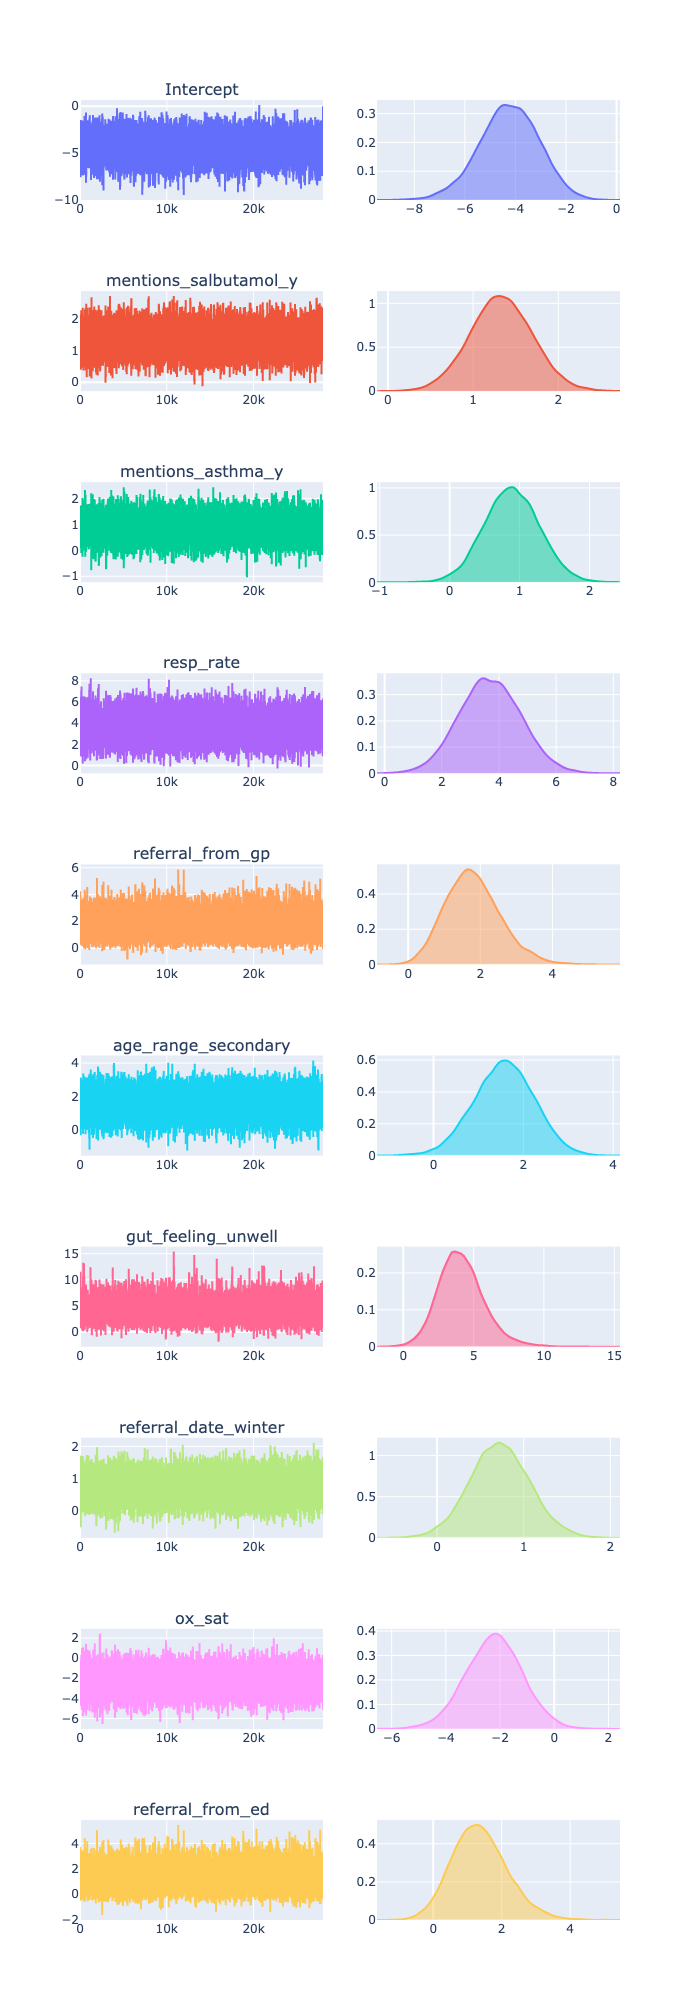

In [4]:
best_trace_fig = return_trace_fig(best_trace)
Image(best_trace_fig.to_image(format="png"))

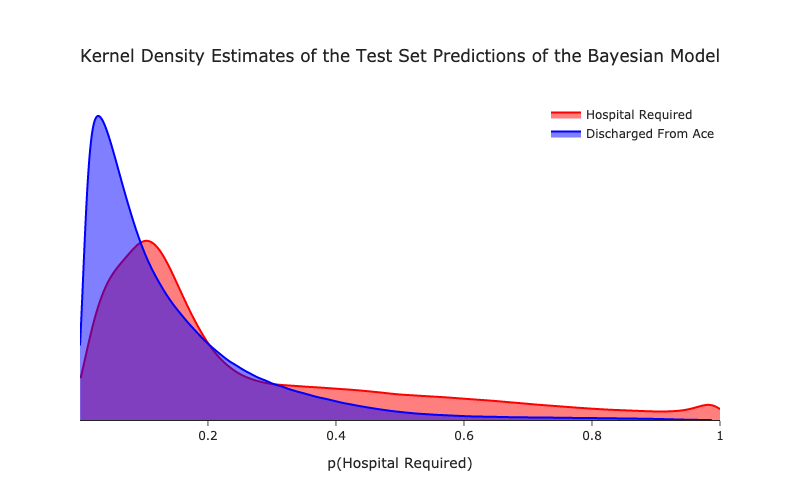

In [40]:
def return_p_hospital(x, trace):
    t = trace["Intercept"]
    features = trace.varnames[1:]
    for feature, value in x[features].items():
        t += trace[feature] * value
    y_hat = 1 / (1 + np.exp(-t))
    return y_hat

def return_pred_kde_fig(X, y, trace):
    pos_example_probs = []
    for _, example in X[y == 1].iterrows():
        p_hospital = return_p_hospital(example, trace)
        pos_example_probs = np.append(pos_example_probs, p_hospital)

    neg_example_probs = []
    for _, example in X[y == 0].iterrows():
        p_hospital = return_p_hospital(example, trace)
        neg_example_probs = np.append(neg_example_probs, p_hospital) 

    fig = go.Figure()
    hr_plot = return_kde_plot(pos_example_probs)
    hr_plot.name = "Hospital Required"
    fig.add_trace(hr_plot)
    ace_plot = return_kde_plot(neg_example_probs, color="blue")
    ace_plot.name = "Discharged From Ace"
    fig.add_trace(ace_plot)
    fig.update_layout(template="simple_white",
                      title=dict(
                          text="Kernel Density Estimates of the Test Set Predictions of the Bayesian Model",
                          y=0.9,
                          x=0.5
                      ),
                      width=800,
                      height=500,
                      xaxis_title="p(Hospital Required)",
                      legend=dict(
                          yanchor="top",
                          y=1,
                          xanchor="right",
                          x=1,
                      ))
    fig.update_yaxes(visible=False)
    return fig


test_pred_kde_fig = return_pred_kde_fig(X_test, y_test, best_trace)
images_dir = '/Users/samrelins/Documents/LIDA/ace_project/written_work/report/images'
test_pred_kde_path = os.path.join(images_dir,"test-pred-kdes.jpg")
test_pred_kde_fig.write_image(test_pred_kde_path, scale=10, format="jpg")
Image(test_pred_kde_fig.to_image(format="png"))

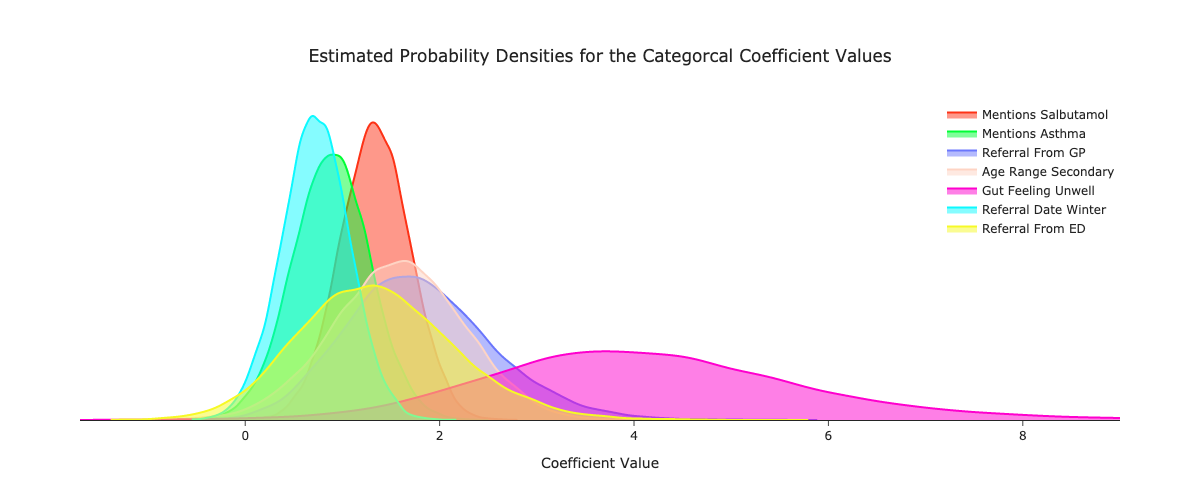

In [33]:
full_feature_names = {
    "mentions_salbutamol_y": "Mentions Salbutamol", 
    "mentions_asthma_y": "Mentions Asthma", 
    "referral_from_gp": "Referral From GP", 
    "age_range_secondary": "Age Range Secondary", 
    "gut_feeling_unwell": "Gut Feeling Unwell", 
    "referral_date_winter": "Referral Date Winter",
    "referral_from_ed": "Referral From ED"
}

def return_coef_dist_fig(pymc_trace, features):
    """
    Helper function to plot KDE plots for coeff estimates
    
    :param pymc_trace: (object: pyMC3 Trace object) input trace
    :param features: (list: list of strings) list of feature names to plot
    
    :return: plotly Figure object
    """
    
    fig = go.Figure()

    for i, feature in enumerate(features):
        samples = pymc_trace[feature]
        color = px.colors.qualitative.Light24[i]
        kde_plot = return_kde_plot(samples, color=color)
        kde_plot.name = full_feature_names[feature]
        fig.add_trace(kde_plot)
    fig.update_layout(template="simple_white",
                      title=dict(
                          text="Estimated Probability Densities for the Categorcal Coefficient Values",
                          y=0.9,
                          x=0.5
                      ),
                      width=1200,
                      height=500,
                      legend=dict(
                          yanchor="top",
                          y=1,
                          xanchor="right",
                          x=1,
                      ))
    fig.update_yaxes(visible=False)
    fig.update_xaxes(range=[-1.7, 9], title_text="Coefficient Value")
    return fig

cat_features = [
    "mentions_salbutamol_y", 
    "mentions_asthma_y", 
    "referral_from_gp", 
    "age_range_secondary", 
    "gut_feeling_unwell", 
    "referral_date_winter",
    "referral_from_ed"
]

coef_dist_fig = return_coef_dist_fig(best_trace, cat_features)
cat_coef_estimates = os.path.join(images_dir,"cat-coef-estimates.jpg")
coef_dist_fig.write_image(cat_coef_estimates, scale=10, format="jpg")
Image(coef_dist_fig.to_image(format="png"))

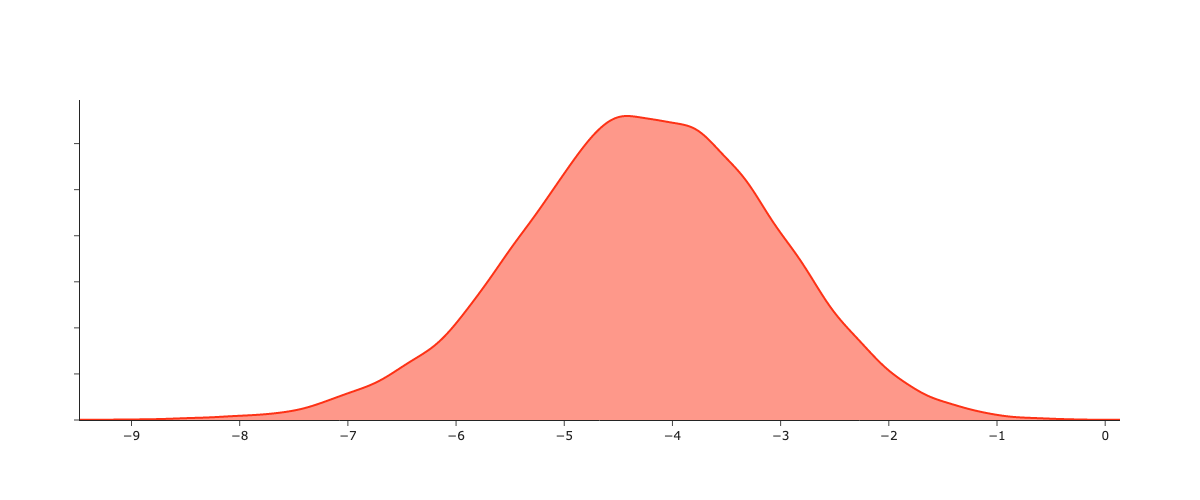

In [8]:
intercept_dist_fig = return_coef_dist_fig(best_trace, ["Intercept"])
Image(intercept_dist_fig.to_image(format="png"))

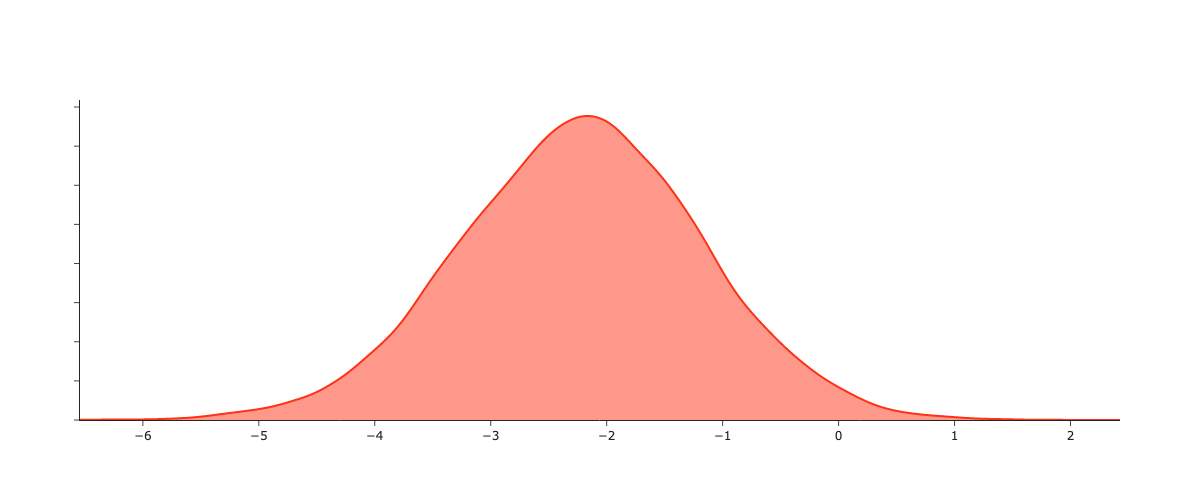

In [9]:
ox_sat_dist_fig = return_coef_dist_fig(best_trace, ["ox_sat"])
Image(ox_sat_dist_fig.to_image(format="png"))

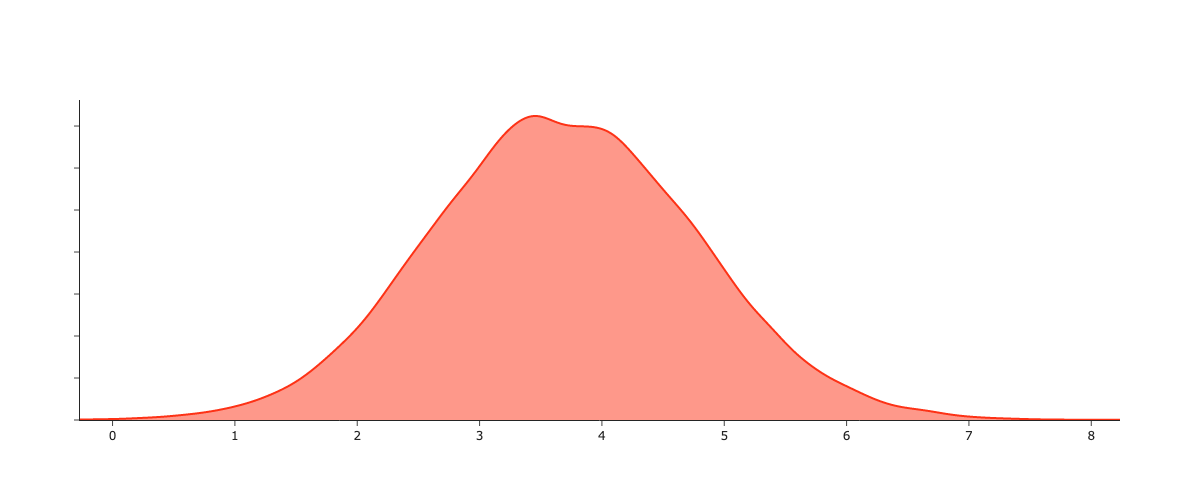

In [10]:
intercept_dist_fig = return_coef_dist_fig(best_trace, ["resp_rate"])
Image(intercept_dist_fig.to_image(format="png"))

In [5]:
best_hpds = pm.hpd(best_trace, hdi_prob=0.95)
best_hpds

<xarray.Dataset>
Dimensions:                (hdi: 2)
Coordinates:
  * hdi                    (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept              (hdi) float64 -6.594 -2.006
    mentions_salbutamol_y  (hdi) float64 0.6422 2.051
    mentions_asthma_y      (hdi) float64 0.1265 1.686
    resp_rate              (hdi) float64 1.573 5.81
    referral_from_gp       (hdi) float64 0.3916 3.351
    age_range_secondary    (hdi) float64 0.2811 2.901
    gut_feeling_unwell     (hdi) float64 0.9999 7.504
    referral_date_winter   (hdi) float64 0.02623 1.398
    ox_sat                 (hdi) float64 -4.272 -0.176
    referral_from_ed       (hdi) float64 -0.1351 3.007

In [12]:
best_features_df = pd.DataFrame()
for feature in ["Intercept"] + best_features:
    
    feature_hpd = best_hpds[feature].data
    if feature in cat_features:
        n_examples = X_train[feature].sum()
    else:
        n_examples = np.nan
        
    best_features_df = best_features_df.append(dict(
        feature=feature,
        hpd_lower=feature_hpd[0],
        hpd_upper=feature_hpd[1],
        n_examples=n_examples
    ), ignore_index=True)
    
best_features_path = os.path.join(outputs_dir, "best_features.csv")
best_features_df = best_features_df.round(decimals=2)
best_features_df.to_csv(best_features_path, index=False)
best_features_df 

,feature,hpd_lower,hpd_upper,n_examples
0,Intercept,-6.59,-2.01,NaN
1,mentions_salbutamol_y,0.64,2.05,72.0
2,mentions_asthma_y,0.13,1.69,73.0
3,resp_rate,1.57,5.81,NaN
4,referral_from_gp,0.39,3.35,193.0
5,age_range_secondary,0.28,2.90,16.0
6,gut_feeling_unwell,1.00,7.50,3.0
7,referral_date_winter,0.03,1.40,111.0
8,ox_sat,-4.27,-0.18,NaN
9,referral_from_ed,-0.14,3.01,90.0


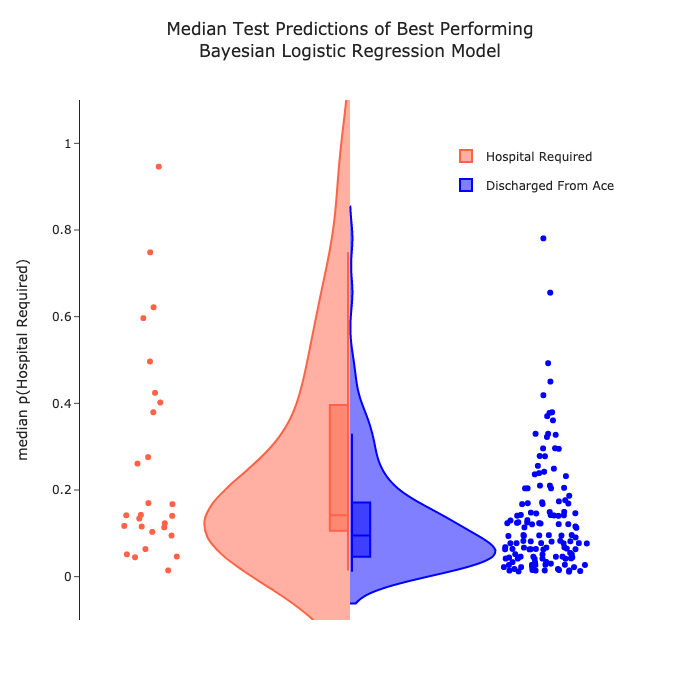

In [53]:
def return_median_pred_plots(X, y, trace):

    pos_example_median_probs = []
    for _, example in X[y == 1].iterrows():
        p_hospital = return_p_hospital(example, trace)
        pos_example_median_probs.append(np.median(p_hospital))
        
    neg_example_median_probs = []
    for _, example in X[y == 0].iterrows():
        p_hospital = return_p_hospital(example, trace)
        neg_example_median_probs.append(np.median(p_hospital))
        
    fig = go.Figure()
    
    pos_name = "Hospital Required"
    pos_box = go.Violin(y=pos_example_median_probs, 
                        x=["Bayes Model Preds"] * len(pos_example_median_probs),
                        points="all", 
                        box_visible=True,
                        legendgroup=pos_name,
                        scalegroup=pos_name,
                        name=pos_name,
                        side="negative",
                        pointpos=-1.35,
                        marker_color="tomato")
    fig.add_trace(pos_box)
    
    neg_name = "Discharged From Ace"
    neg_box = go.Violin(y=neg_example_median_probs,  
                        x=["Bayes Model Preds"] * len(neg_example_median_probs),
                        points="all", 
                        legendgroup=neg_name,
                        scalegroup=neg_name,
                        name=neg_name,
                        box_visible=True,
                        side="positive",
                        pointpos=1.35,
                        marker_color="blue")
    fig.add_trace(neg_box)
    fig.update_layout(template="simple_white",
                      title=dict(
                          text="Median Test Predictions of Best Performing<br>Bayesian Logistic Regression Model",
                          y=0.95,
                          x=0.5
                      ),
                      width=700,
                      height=700,
                      yaxis_title="median p(Hospital Required)",
                      legend=dict(
                          yanchor="top",
                          y=0.92,
                          xanchor="right",
                          x=1,
                      ))
    fig.update_xaxes(visible=False)
    fig.update_yaxes(range=[-0.1,1.1])
    return fig

median_preds_fig = return_median_pred_plots(X_test, y_test, best_trace)
median_preds_path = os.path.join(images_dir,"median-preds.jpg")
median_preds_fig.write_image(median_preds_path, scale=10, format="jpg")
Image(median_preds_fig.to_image(format="png"))

In [100]:
y_hat_train = []
for _, example in X_train.iterrows():
    pred = np.median(return_p_hospital(example, best_trace))
    y_hat_train.append(pred)
y_hat_train = np.array(y_hat_train)
    
y_hat_test = []
for _, example in X_test.iterrows():
    pred = np.median(return_p_hospital(example, best_trace))
    y_hat_test.append(pred)
y_hat_test = np.array(y_hat_test)

roc_auc_score(y_train, y_hat_train)

0.7639569716775599

In [101]:
roc_auc_score(y_test, y_hat_test)

0.671604938271605

In [102]:
from sklearn.metrics import f1_score

best_f1_score = 0
best_f1_prob = 0
for i in np.arange(0, 1, 0.01):
    preds = np.array(y_hat_train > i, dtype="int")
    i_f1_score = f1_score(y_train, preds)
    if i_f1_score > best_f1_score:
        best_f1_score = i_f1_score
        best_f1_prob = i

In [103]:
best_f1_score

0.46875

In [104]:
y_test_preds = np.array(y_hat_test > 0.4, dtype="int")
f1_score(y_test, y_test_preds)

0.3157894736842105